In [1]:
import torch
from torch import nn

import torch.functional as F

from PIL import Image
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import requests
import io

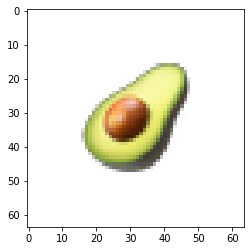

In [2]:
def load_image(url, max_size=32, padding=16):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    img = np.pad(img,((padding,padding),(padding,padding),(0,0)))
    
    img[..., :3] *= img[..., 3:]
    
    img = torch.Tensor(img).float().cuda()
    img = img.transpose(0,2)

    return img


def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://raw.githubusercontent.com/iamcal/emoji-data/master/img-apple-64/%s.png' % code
    return load_image(url)


image = load_emoji("🥑")

plt.imshow(image.transpose(0,2).cpu())

img_size = 64

In [13]:
class Automata(nn.Module):

    def __init__(self, grid_size, n_channels):

        super(Automata, self).__init__()

        self.n_channels = n_channels
        self.grid_size = grid_size

        self.filters = torch.Tensor([[[[-1, 0, 1],
                                       [-2, 0, 2],
                                       [-1, 0, 1]
                                       ]],
                                     [[[-1, -2, -1],
                                       [0, 0, 0],
                                       [1, 2, 1]
                                       ]],
                                     [[[0, 0, 0],
                                       [0, 1, 0],
                                       [0, 0, 0]
                                       ]]]).cuda()

        self.mapper = nn.Sequential(
            nn.Linear(3*n_channels, 128),
            nn.ReLU(),
            nn.Linear(128, n_channels),
            nn.Tanh()
        )

        self.mapper[2].weight.data.fill_(0)
        self.mapper[2].bias.data.fill_(0)

    def perception(self, x):

        # reshape for same convolution across channels
        x = x.reshape(-1, 1, self.grid_size[0], self.grid_size[1])

        # toroidal padding
        conved = nn.functional.pad(x, (1, 1, 1, 1), mode="reflect")

        conved = nn.functional.conv2d(conved, model.filters)

        # reshape for perception computations
        conved = conved.view(self.batch_size, 3*self.n_channels, -1)
        conved = conved.transpose(1, 2)

        conved = self.mapper(conved)

        conved = conved.transpose(1, 2)
        # (batch_size, channels, total_cells)

        conved = conved.view(self.batch_size, self.n_channels, *self.grid_size)

        can_update = torch.rand_like(conved) < 0.75

        return conved*can_update

    def forward(self, x, iterations, keep_history=False):

        if keep_history:

            model.history = torch.zeros(iterations, *x.shape)

        model.batch_size = x.shape[0]

        for i in range(iterations):

            conved = self.perception(x)

            x = x + conved

            is_alive = nn.functional.max_pool2d(
                x[:, 3], (3, 3), stride=1, padding=1) > 1/8

            is_alive = is_alive[:, None]

            x = x*is_alive

            x[:, :4].clamp_(0, 1)

            if keep_history:

                model.history[i] = x

        return x

In [14]:
n_channels = 16
n_epochs = 5000
lr = 0.001
pool_size = 1024
batch_size = 8

model = Automata((64, 64), n_channels).cuda()

# initialize pool with seeds
seed = torch.zeros(n_channels,img_size,img_size).cuda()
seed[3:,32,32] = 1

pool_initials = seed[None, :].repeat(pool_size,1,1,1)
pool_targets = image[None,:].repeat(pool_size,1,1,1)

losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):
    
    iterations = random.randint(64,96)

    pool_indices = random.sample(range(pool_size),batch_size)
        
    initial_states = pool_initials[pool_indices]
    
    targets = pool_targets[pool_indices]

    out = model(initial_states,iterations)
    
    phenotypes = out[:,:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)
    
    per_sample_loss = loss.mean((1,2,3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()
    
    max_loss_idx = per_sample_loss.argmax()
    
    replacements = out.detach()
    replacements[max_loss_idx] = seed.clone()

    pool_initials[pool_indices] = replacements

    if i % 10 == 0:
    
        print(i, np.log10(float(total_loss.cpu().detach())))
        
    losses.append(float(total_loss))

0 -1.0723602581784166
10 -1.475671016506349
20 -1.3497567217906727
30 -1.2568702588712886
40 -1.5684107695893077
50 -1.163284758814532
60 -1.5398570933211182
70 -1.506525534494811
80 -1.3542381158202104
90 -1.3939009903299795
100 -1.5135967976204314
110 -1.5215029132433797
120 -1.4715196942509132
130 -1.2259519983010103
140 -1.6021046404468988
150 -1.3703278009830302
160 -1.4747714113433457
170 -1.6876483201802088
180 -1.5639898597495656
190 -1.5223733559859196
200 -1.5286178121274854
210 -1.4356280400965356
220 -1.5061358764171255
230 -1.4306905230370128
240 -1.6423527326479008
250 -1.6251286794118804
260 -1.595244673370223
270 -1.7259930412642301
280 -1.5525590929624564
290 -1.583889492777392
300 -1.6158270798979424
310 -1.6730218658815061
320 -1.5864824592568858
330 -1.6005552224825175
340 -1.5788640398999734
350 -1.5259707865108698
360 -1.6824191824148746
370 -1.625188261695796
380 -1.6330900301232136
390 -1.692645509733393
400 -1.6727112633737782
410 -1.7355558457012303
420 -1.762

3380 -3.1549672008773086
3390 -3.1321524121167537
3400 -3.202745602101573
3410 -3.082833487615474
3420 -2.9039541124108035
3430 -2.6508231898633188
3440 -3.029152801895337
3450 -3.1862619604061666
3460 -2.956990893310713
3470 -2.917374894544466
3480 -3.111581869955387
3490 -3.288094984575981
3500 -3.2593876254998766
3510 -3.241568014211351
3520 -3.1810515181116807
3530 -3.0641728504231707
3540 -3.2242937415691455
3550 -3.098028015356903
3560 -2.988950164640939
3570 -3.112442300279663
3580 -2.63701384060423
3590 -3.127891592262926
3600 -3.1055080318413473
3610 -3.116243569006177
3620 -3.059704530879025
3630 -2.9984979075426543
3640 -3.2107886377498773
3650 -3.016825457592247
3660 -3.156740196097505
3670 -2.942434639852067
3680 -3.221631718596027
3690 -3.2422597957658574
3700 -3.4163201896646256
3710 -2.9065331771432215
3720 -3.0639733605314685
3730 -3.276797375841541
3740 -3.157993302403513
3750 -3.087141728751186
3760 -3.237172067941633
3770 -3.2053415850988443
3780 -3.1721210053976288

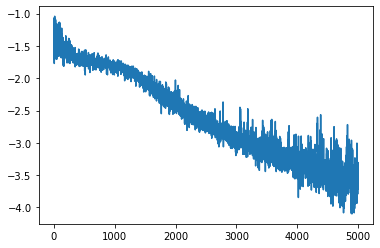

In [15]:
plt.plot(np.log10(losses))

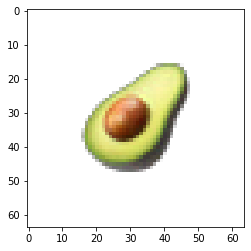

In [16]:
plt.imshow(pool_initials[589,:4].transpose(0,2).cpu())

In [18]:
out = model(seed[None,:],512,keep_history=True).squeeze()

In [19]:
video = model.history.cpu().detach()
video = video[:,0,:4]
video = video.transpose(1,3)

In [20]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close()

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init,  frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())